In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchinfo import summary
import pickle
import sys, os
import time
main_path = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.insert(1, main_path)
import GD
from SPN import SPN
import utils
from viz import plot_UAV_FLPO, plot_UAV_FLPO_3D
from pathlib import Path
from Anneal import anneal
np.random.seed(42)


# Load a Scenario

In [2]:
seed=3
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
np.random.seed(seed)
scene_path = "benchmark_data/N10_M4_ends2_seed3"
print("Running on: " , device)

with open(scene_path, 'rb') as file:
    data = pickle.load(file)
START_locs = data["START_locs"]
F_base = data["F_base"]
END_locs = data["END_locs"]
num_drones = START_locs.shape[0]
num_facilities = F_base.shape[-2]
dim_ = F_base.shape[-1]
num_distinct_ends = len(torch.unique(END_locs, dim=0))
print(f"num_drones = {num_drones}\t num_facilities = {num_facilities}\t dim = {dim_}\t num_distinct_ends = {num_distinct_ends}")
assert(F_base.requires_grad == True)

s = START_locs.cpu().numpy().reshape(-1,1,2)
e = END_locs.cpu().numpy().reshape(-1,1,2)
Y_init = F_base.detach().cpu().numpy()

n_algo_iters = 10
discardPSO = True
discardACO = True

# plot_UAV_FLPO(START_locs, END_locs, F_base, (12,10))
# # plot_UAV_FLPO_3D(START_locs, END_locs, F_base)

Running on:  cuda
num_drones = 10	 num_facilities = 4	 dim = 2	 num_distinct_ends = 2


In [3]:
# create a dataset of nodes and agents
# num_nodes = 10
# num_agents = 30
# dim = 2  # dimension of the space
# def generate_example(dim=2, num_nodes=30, num_agents=20):
#     nodes = 0.5 + 0.01 * np.random.randn(1, num_nodes, dim)  # centered at [0.5, 0.5] with small perturbation
#     s = np.random.rand(num_agents,1, dim)
#     e = np.random.rand(num_agents,1, dim)
#     return s, e, nodes
# s, e, Y_init = generate_example(num_nodes=num_facilities, num_agents=num_drones, dim=dim)

Text(0.5, 1.0, 'Nodes and Agents in 2D Space')

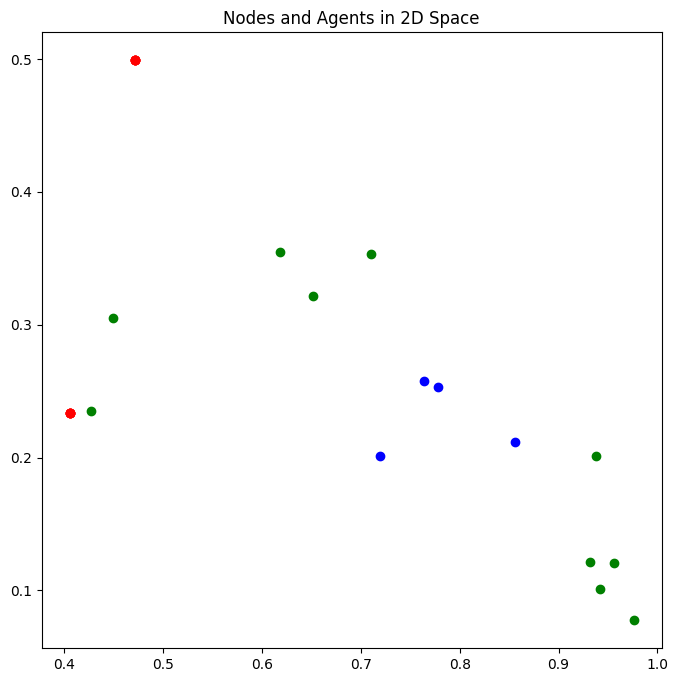

In [4]:

# plot the nodes and agents
plt.figure(figsize=(8, 8))
plt.scatter(Y_init[0, :, 0], Y_init[0, :, 1], c='blue', label='Nodes')
plt.scatter(s[:, 0, 0], s[:, 0, 1], c='green', label='Start Points')
plt.scatter(e[:, 0, 0], e[:, 0, 1], c='red', label='End Points')
plt.title('Nodes and Agents in 2D Space')

# PSO

In [5]:
# run the PSO algorithm
from PSO import pso, pso_plot, pso_print

if discardPSO:
    t_pso_arr = None
    c_pso_arr = None
    t_pso_min = None
    c_pso_min = None
else:
    num_particles = 500
    num_iters = 300
    w = 0.9 # inertia weight
    c1 = 0.5  # cognitive (individual) weight
    c2 =1.5  # social (group) weight
    t_pso_arr = []
    c_pso_arr = []
    for i in range(n_algo_iters):
        y_final, eta_final, global_best_cost, elapsed_time = pso(
            s,
            e,
            num_facilities,
            num_drones,
            dim_,
            Y_init=Y_init,
            verbose=True,
            w=w,
            c1=c1,
            c2=c2,
            num_particles=num_particles,
            num_iters=num_iters,
        )
        t_pso_arr.append(elapsed_time)
        c_pso_arr.append(global_best_cost)

    t_pso_min = np.min(t_pso_arr)
    c_pso_min = np.min(c_pso_arr)
    pso_print(y_final, eta_final, global_best_cost, elapsed_time, s, e)
    pso_plot(y_final, eta_final, s, e)

In [6]:
t_pso_min, c_pso_min

(None, None)

# Genetic Algorithm

In [7]:
from GA import ga, ga_plot, ga_print
t_ga_arr = []
c_ga_arr = []
for i in range(n_algo_iters):
    best_y, best_eta, best_cost, elapsed_time = ga(
            s,
            e,
            num_facilities,
            num_drones,
            dim_,
            Y_init=None,
            verbose=False,
            pop_size=100,
            generations=8000,
            mutation_rate=0.3,        
        )
    t_ga_arr.append(elapsed_time)
    c_ga_arr.append(best_cost)
t_ga_min = np.min(t_ga_arr)
c_ga_min = np.min(c_ga_arr)
# ga_print(s, e, best_y, best_eta, best_cost, elapsed_time)
# ga_plot(s, e, best_y, best_eta)

In [8]:
t_ga_min, c_ga_min

(189.04747009277344, 0.7236140377913871)

# SA

In [9]:
from SA import sa, plot_sa, print_sa
t_sa_arr = []
c_sa_arr = []
for i in range(n_algo_iters):
    best_y, best_eta, best_cost, elapsed_time = sa(
            s,
            e,
            num_facilities,
            num_drones,
            dim_,
            Y_init=Y_init,
            YMIN=0,
            YMAX=1.0,
            iters=50000,
            verbose=False,
        )
    t_sa_arr.append(elapsed_time)
    c_sa_arr.append(best_cost)
t_sa_min = np.min(t_sa_arr)
c_sa_min = np.min(c_sa_arr)
# print_sa(s, e, best_y, best_eta)
# plot_sa(s, e, best_y, best_eta)

In [10]:
t_sa_min, c_sa_min

(10.23348879814148, 1.0641702400588493)

# CEM

In [11]:
from CEM import cem, plot_cem, print_cem

t_cem_arr = []
c_cem_arr = []
for i in range(n_algo_iters):
    best_y, best_eta, best_cost, elapsed_time = cem(
            s,
            e,
            num_facilities,
            num_drones,
            dim_,
            Y_init=Y_init,
            YMIN=0,
            YMAX=1.0,
            n_iter=2000,
            pop_size=100,
            elite_frac=0.2,
            verbose=False,
        )
    t_cem_arr.append(elapsed_time)
    c_cem_arr.append(best_cost)
t_cem_min = np.min(t_cem_arr)
c_cem_min = np.min(c_cem_arr)
# print_cem(s, e, best_y, best_eta, best_cost, elapsed_time)
# plot_cem(s, e, best_y, best_eta)

In [12]:
t_cem_min, c_cem_min

(144.31296753883362, 0.9310474284740996)

# ACO

In [13]:
from ACO import aco, plot_aco, print_aco

if discardACO:
    t_aco_arr = None
    c_aco_arr = None
    t_aco_min = None
    c_aco_min = None
else:
    t_aco_arr = []
    c_aco_arr = []
    for i in range(n_algo_iters):
        best_y, best_eta, best_cost, elapsed_time = aco(
            s,
            e,
            num_facilities,
            num_drones,
            dim_,
            Y_init=Y_init,
            YMIN=0.0,
            YMAX=1.0,
            num_iters=200,
            num_ants=100,
            alpha=1.0,
            beta=1.0,
            rho=0.5,
            Q=1.0,
            verbose=True,
        )
        t_aco_arr.append(elapsed_time)
        c_aco_arr.append(best_cost)
    t_aco_min = np.min(t_aco_arr)
    c_aco_min = np.min(c_aco_arr)
    print_aco(s, e, num_facilities, num_drones, dim_, best_y, best_eta)
    plot_aco(s, e, num_facilities, num_drones, dim_, best_y, best_eta)

In [14]:
t_aco_min, c_aco_min

(None, None)

# Run benchmark iterations for our algorithm

### Load the SPN Module

In [15]:
torch.cuda.empty_cache()
model_classes = {"SPN": SPN}
weights_address = (
    Path(main_path + "/Saved_models") /
    "FT100_FastAnneal_2025_07_19_01_50_51.pth"
)
spn = utils.load_model(
    weights_address, model_classes, weights_only=True, device=device
)
for param in spn.parameters():
    param.requires_grad = False
print("SPN loaded on: ", spn.device)
print(summary(spn))

Model created.
SPN loaded on:  cuda
Layer (type:depth-idx)                                       Param #
SPN                                                          --
├─LinearAttnEncoder: 1-1                                     2,048
│    └─ModuleList: 2-1                                       --
│    │    └─MultiheadAttention: 3-1                          (66,048)
│    │    └─MultiheadAttention: 3-2                          (66,048)
│    │    └─MultiheadAttention: 3-3                          (66,048)
│    │    └─MultiheadAttention: 3-4                          (66,048)
│    │    └─MultiheadAttention: 3-5                          (66,048)
│    │    └─MultiheadAttention: 3-6                          (66,048)
│    └─ModuleList: 2-2                                       --
│    │    └─MultiheadAttention: 3-7                          (66,048)
│    │    └─MultiheadAttention: 3-8                          (66,048)
│    │    └─MultiheadAttention: 3-9                          (66,048)
│    │

### Using SPN and Path Sampling

In [16]:
optim_iters = 100
optim_step = 0.01
b_min = 1e4
beta = 1e4
tol = 1e-3

t_flpoINF_arr = []
c_flpoINF_arr = []
START_locs = START_locs.to(device)
F_base = F_base.to(device)
END_locs = END_locs.to(device)
for i in range(n_algo_iters):

    tic = time.time()
    F_base0_anneal = F_base.clone().detach().requires_grad_(True).to(device)
    Y_arr_adam, FreeEnergy_adam, G_adam = GD.Adam_at_beta(
        F_base0_anneal, START_locs, END_locs, spn, optim_iters,
        optim_step, tol=tol, allowPrint=False, return_list=True)
    toc = time.time()

    t_flpoINF_arr.append(toc-tic)
    c_flpoINF_arr.append(FreeEnergy_adam.detach().item())

t_flpoINF_min = np.min(t_flpoINF_arr)
c_flpoINF_min = np.min(c_flpoINF_arr)

# plot_UAV_FLPO(START_locs, END_locs, Y_arr_adam[-1], (12,6))


In [17]:
t_flpoINF_min, c_flpoINF_min 

(1.0161068439483643, 0.06272906810045242)

### Use SPN

In [18]:
beta_min = 1e-3 
beta_max = 1e4
beta_grow = 10
optim_iters = 100
optim_step = 0.01 # 0.1 for gd0, sampling_gd, use < 0.01 for the other two optimizers 
optim_name = "sampling_auto_diff"
tol = 0.001
n_path_samples = 8

t_flpoANN_arr = []
c_flpoANN_arr = []

for i in range(n_algo_iters):
    tic = time.time()
    F_base0_anneal = F_base.clone().detach().requires_grad_(True)
    Y_arr, b_arr, F_arr = anneal( 
            F_base0_anneal, 
            START_locs, 
            END_locs, 
            spn,  
            optim_iters, 
            optim_step, 
            beta_min, 
            beta_max, 
            beta_grow, 
            tol=tol, 
            optimizer_name=optim_name, 
            n_path_samples=n_path_samples, 
            allowPrint=False 
        ) 
    toc = time.time()
    runtime_anneal = toc-tic 
    t_flpoANN_arr.append(runtime_anneal)
    c_flpoANN_arr.append(F_arr[-1])

t_flpoANN_min = np.min(t_flpoANN_arr)
c_flpoANN_min = np.min(c_flpoANN_arr)

# plot_UAV_FLPO(START_locs, END_locs, Y_arr[-1], (12,6))


In [19]:
t_flpoINF_min, c_flpoANN_min

(1.0161068439483643, 0.061535585671663284)

### Print the benchmark table for all the methods

In [20]:
print(f"---------------------------------------------------------------------------------------")
print(f"Method \t\t\t\t Cost \t\t\t\t Time (s)")
print(f"---------------------------------------------------------------------------------------")
if discardPSO:
    print(f"PSO \t\t\t\t NA \t\t\t\t NA")
else:
    print(f"PSO \t\t\t\t {t_pso_min:.2f} \t\t\t\t {c_pso_min:.3f}")
print(f"GA \t\t\t\t {c_ga_min:.2f} \t\t\t\t {t_ga_min:.1f}")
print(f"SA \t\t\t\t {c_sa_min:.2f} \t\t\t\t {t_sa_min:.1f}")
print(f"CEM \t\t\t\t {c_cem_min:.2f} \t\t\t\t {t_cem_min:.1f}")
if discardACO:
    print(f"ACO \t\t\t\t NA \t\t\t\t NA")
else:
    print(f"ACO \t\t\t\t {c_aco_min:.3f} \t\t\t\t {t_aco_min:.2f}")
print(f"d-FLPO (I) \t\t\t\t {c_flpoINF_min:.3f} \t\t\t\t {t_flpoINF_min:.3f}")
print(f"d-FLPO (A) \t\t\t\t {c_flpoANN_min:.3f} \t\t\t\t {t_flpoANN_min:.3f}")
print(f"---------------------------------------------------------------------------------------")

---------------------------------------------------------------------------------------
Method 				 Cost 				 Time (s)
---------------------------------------------------------------------------------------
PSO 				 NA 				 NA
GA 				 0.72 				 189.0
SA 				 1.06 				 10.2
CEM 				 0.93 				 144.3
ACO 				 NA 				 NA
d-FLPO (I) 				 0.063 				 1.016
d-FLPO (A) 				 0.062 				 20.246
---------------------------------------------------------------------------------------


# Save benchmark data

In [21]:
import pickle

benchmark_data = {
    "START_locs":START_locs, 
    "F_base":F_base, 
    "END_locs":END_locs,
    "n_algo_iters":n_algo_iters,
    "t_pso_arr":t_pso_arr,
    "c_pso_arr":c_pso_arr,
    "t_ga_arr":t_ga_arr,
    "c_ga_arr":c_ga_arr,
    "t_sa_arr":t_sa_arr,
    "c_sa_arr":c_sa_arr,
    "t_cem_arr":t_cem_arr,
    "c_cem_arr":c_cem_arr,
    "t_aco_arr":t_aco_arr,
    "c_aco_arr":c_aco_arr,
    "t_flpoINF_arr":t_flpoINF_arr,
    "c_flpoINF_arr":c_flpoINF_arr,
    "t_flpoANN_arr":t_flpoANN_arr,
    "c_flpoANN_arr":c_flpoANN_arr
}

scenario = f"N{int(num_drones)}_M{int(num_facilities)}_ends{int(num_distinct_ends)}_seed{int(seed)}"
filepath = "benchmark_data/" + scenario
print(filepath)

with open(filepath, 'wb') as file:
    pickle.dump(benchmark_data, file)

benchmark_data/N10_M4_ends2_seed3
